# Assignment 8 - Unsupervised Learning

Jonathan Chia - jchia3 - due 10/22/2023

In [1]:
# Key Packages
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd


# Modeling
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.tree import DecisionTreeClassifier

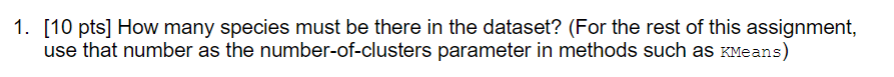

## 1. Species

In [2]:
df = pd.read_csv('clustering_synthetic_dataset.csv')

Looks like there are 3 species in this dataset.

Text(0.5, 1.0, 'Species by F1 and F2')

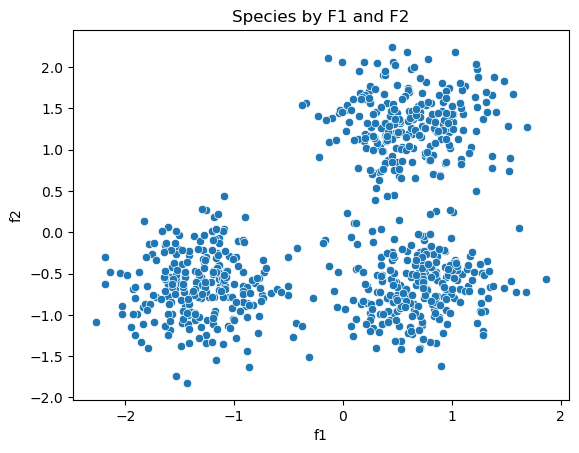

In [3]:
sns.scatterplot(data=df, x='f1', y='f2')
plt.title('Species by F1 and F2')

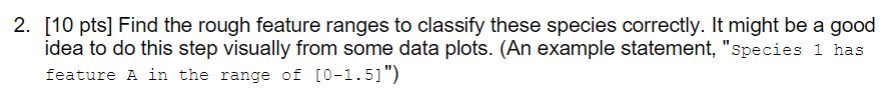

## 2. Feature Ranges

Based on the above plot, these are the feature ranges:

* the bottom left circle - Species 1

    * f1: [-3, 0]
    * f2: [-2, 0.5]

* the bottom right circle - Species 2

    * f1: [0,2]
    * f2: [-2, 0.5]

* the top right circle - Species 3

    * f1: [-0.5, 2]
    * f2: [0.5, 3] 

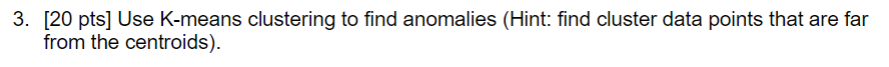

## 3. KMeans

Features are on the same scale so we don't need to do any standardization or min-max scaling

In [4]:
km = KMeans(n_clusters = 3, init='k-means++',
            n_init='auto',
            max_iter=300,
            random_state=0)

y_km = km.fit_predict(df)

c:\Users\jonat\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


Let's look at how the kmeans did:

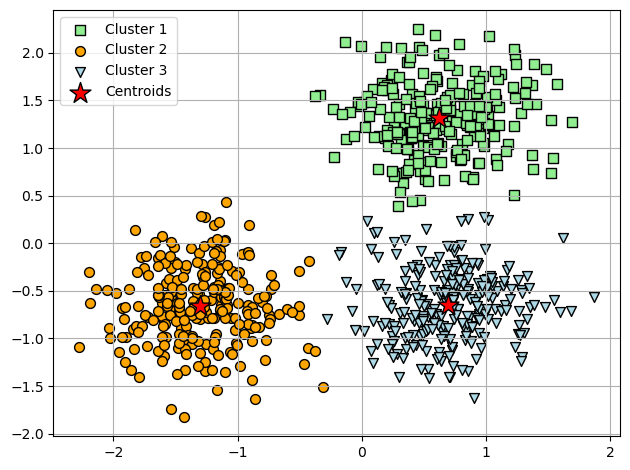

In [5]:
# Visualizing using the code from the textbook
plt.scatter(df.loc[y_km == 0].f1, df.loc[y_km == 0].f2, s=50, c='lightgreen', marker='s', edgecolor='black', label='Cluster 1') 
plt.scatter(df.loc[y_km == 1].f1, df.loc[y_km == 1].f2, s=50, c='orange', marker='o', edgecolor='black', label='Cluster 2') 
plt.scatter(df.loc[y_km == 2].f1, df.loc[y_km == 2].f2, s=50, c='lightblue', marker='v', edgecolor='black', label='Cluster 3') 
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, marker='*', c='red', edgecolor='black', label='Centroids') 
plt.legend(scatterpoints=1) 
plt.grid() 
plt.tight_layout() 
plt.show()

Looks pretty good! Since these are all circles, KMeans works well here.

We can use intracluster distance to mark the dots that are outside our outlier threshold. This threshold will work for each species since each cluster has about the same size.

### Finding Outliers

In [6]:
from collections import defaultdict
from functools import partial

# Define a distance measure
eucl_dist = lambda a, b : np.sqrt(np.sum((a-b)**2))

First let's get f1 and f2 into an np.array() and then get the cluster centers into an np.array() so I can calculate the euclidean distance on them.

In [7]:
df['point'] = [np.array(x) for x in zip(df.f1, df.f2)]

In [8]:
df['cluster_number'] = y_km

In [9]:
df['centroid'] = df.cluster_number.apply(lambda x: km.cluster_centers_[x])

In [10]:
df.head()

,f1,f2,point,cluster_number,centroid
0,0.494261,1.451067,"[0.494260967249, 1.45106696541]",0,"[0.6226055466319168, 1.3172598049576816]"
1,-1.428081,-0.837064,"[-1.42808099324, -0.83706376669]",1,"[-1.3026621090330555, -0.6570420460368406]"
2,0.338559,1.038759,"[0.338559182384, 1.03875870939]",0,"[0.6226055466319168, 1.3172598049576816]"
3,0.119001,-1.053976,"[0.119001013781, -1.05397553336]",2,"[0.6954587036464739, -0.6444233441131201]"
4,1.122425,1.774937,"[1.12242460445, 1.77493654436]",0,"[0.6226055466319168, 1.3172598049576816]"


Calculate the euclidean distance:

In [11]:
df['distance'] = df.apply(lambda row: eucl_dist(row['point'], row['centroid']), axis=1)

Output the quantile for each of the distances grouped by cluster number.

In [12]:
df['distance_quantile'] = df.groupby('cluster_number').distance.rank(pct=True)

Assign cluster == 3 to points that are outside the quantile distance outlier threshold:

In [13]:
outlier_threshold = 0.9
df['new_cluster_number'] = df.apply(lambda row: 3 if row['distance_quantile'] > outlier_threshold else row['cluster_number'], axis=1)

In [14]:
df.head()

,f1,f2,point,cluster_number,centroid,distance,distance_quantile,new_cluster_number
0,0.494261,1.451067,"[0.494260967249, 1.45106696541]",0,"[0.6226055466319168, 1.3172598049576816]",0.185410,0.125000,0
1,-1.428081,-0.837064,"[-1.42808099324, -0.83706376669]",1,"[-1.3026621090330555, -0.6570420460368406]",0.219403,0.158730,1
2,0.338559,1.038759,"[0.338559182384, 1.03875870939]",0,"[0.6226055466319168, 1.3172598049576816]",0.397800,0.439516,0
3,0.119001,-1.053976,"[0.119001013781, -1.05397553336]",2,"[0.6954587036464739, -0.6444233441131201]",0.707133,0.848000,2
4,1.122425,1.774937,"[1.12242460445, 1.77493654436]",0,"[0.6226055466319168, 1.3172598049576816]",0.677707,0.794355,0


Now our boundaries are more refined around each cluster. You can see that each cluster is cleary separate from another. We could use an SVM to create a classifier with high accuracy. 

C:\Users\jonat\AppData\Local\Temp\ipykernel_25464\3584063013.py:4: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(df.loc[df.new_cluster_number == 3].f1, df.loc[df.new_cluster_number == 3].f2, s=50, c='grey', marker='x', edgecolor='black', label='Cluster Outliers')


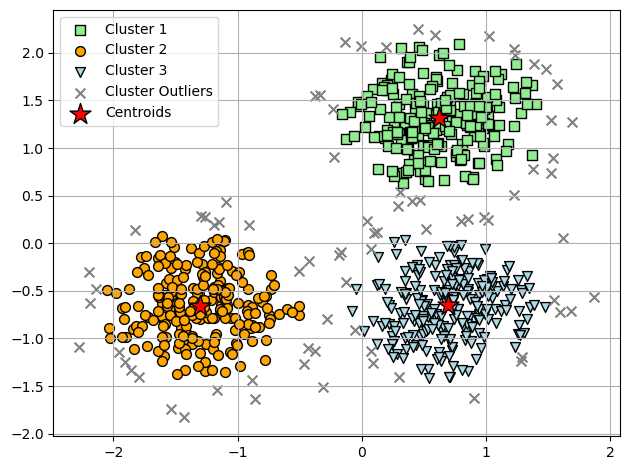

In [15]:
plt.scatter(df.loc[df.new_cluster_number == 0].f1, df.loc[df.new_cluster_number == 0].f2, s=50, c='lightgreen', marker='s', edgecolor='black', label='Cluster 1') 
plt.scatter(df.loc[df.new_cluster_number == 1].f1, df.loc[df.new_cluster_number == 1].f2, s=50, c='orange', marker='o', edgecolor='black', label='Cluster 2') 
plt.scatter(df.loc[df.new_cluster_number == 2].f1, df.loc[df.new_cluster_number == 2].f2, s=50, c='lightblue', marker='v', edgecolor='black', label='Cluster 3') 
plt.scatter(df.loc[df.new_cluster_number == 3].f1, df.loc[df.new_cluster_number == 3].f2, s=50, c='grey', marker='x', edgecolor='black', label='Cluster Outliers') 
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], s=250, marker='*', c='red', edgecolor='black', label='Centroids') 
plt.legend(scatterpoints=1) 
plt.grid() 
plt.tight_layout() 
plt.show()

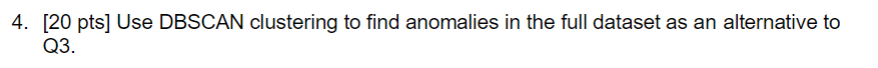

## 4. DBSCAN

In [16]:
db = DBSCAN(metric='euclidean', eps=0.2)

y_db = db.fit_predict(df[['f1', 'f2']])

In [17]:
np.unique(y_db)

array([-1,  0,  1,  2], dtype=int64)

Oh wow looks like the DBSCAN did a great job of finding the clusters and marking the outliers.

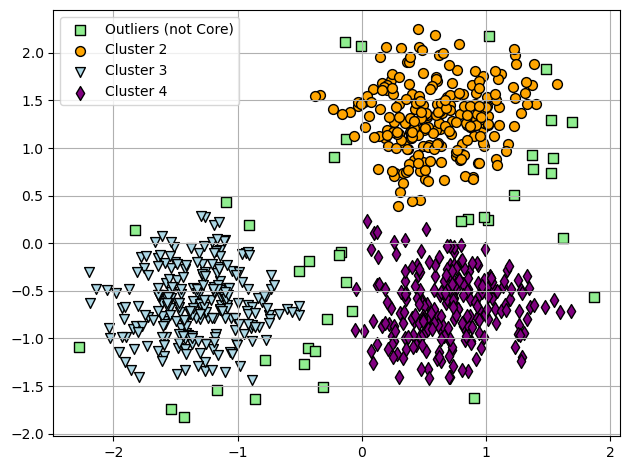

In [18]:
# Visualizing using the code from the textbook
plt.scatter(df.loc[y_db == -1].f1, df.loc[y_db == -1].f2, s=50, c='lightgreen', marker='s', edgecolor='black', label='Outliers (not Core)') 
plt.scatter(df.loc[y_db == 0].f1, df.loc[y_db == 0].f2, s=50, c='orange', marker='o', edgecolor='black', label='Cluster 2') 
plt.scatter(df.loc[y_db == 1].f1, df.loc[y_db == 1].f2, s=50, c='lightblue', marker='v', edgecolor='black', label='Cluster 3') 
plt.scatter(df.loc[y_db == 2].f1, df.loc[y_db == 2].f2, s=50, c='purple', marker='d', edgecolor='black', label='Cluster 4') 
plt.legend(scatterpoints=1) 
plt.grid() 
plt.tight_layout() 
plt.show()

What if I adjust the epsilon? 

In [19]:
db = DBSCAN(metric='euclidean', eps=0.5)

y_db = db.fit_predict(df[['f1', 'f2']])

In [20]:
np.unique(y_db)

array([0], dtype=int64)

Whoops it put it all in the same cluster.

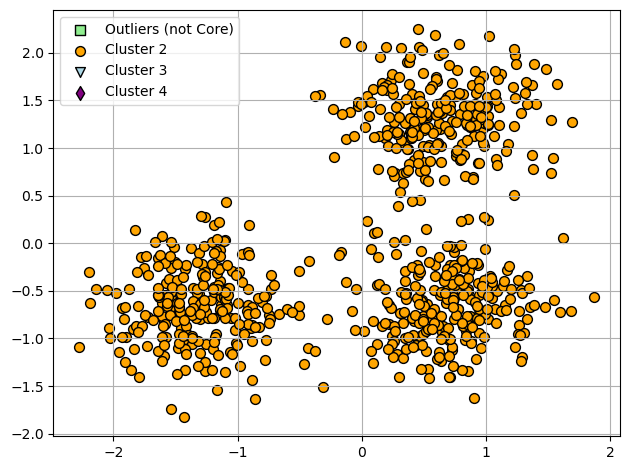

In [21]:
# Visualizing using the code from the textbook
plt.scatter(df.loc[y_db == -1].f1, df.loc[y_db == -1].f2, s=50, c='lightgreen', marker='s', edgecolor='black', label='Outliers (not Core)') 
plt.scatter(df.loc[y_db == 0].f1, df.loc[y_db == 0].f2, s=50, c='orange', marker='o', edgecolor='black', label='Cluster 2') 
plt.scatter(df.loc[y_db == 1].f1, df.loc[y_db == 1].f2, s=50, c='lightblue', marker='v', edgecolor='black', label='Cluster 3') 
plt.scatter(df.loc[y_db == 2].f1, df.loc[y_db == 2].f2, s=50, c='purple', marker='d', edgecolor='black', label='Cluster 4') 
plt.legend(scatterpoints=1) 
plt.grid() 
plt.tight_layout() 
plt.show()

How about a smaller epsilon? 

In [22]:
db = DBSCAN(metric='euclidean', eps=0.15)

y_db = db.fit_predict(df[['f1', 'f2']])

In [23]:
np.unique(y_db)

array([-1,  0,  1,  2,  3], dtype=int64)

Now it made a random smaller cluster. Let's try manipulating the min_samples. Each cluster should have like 20.

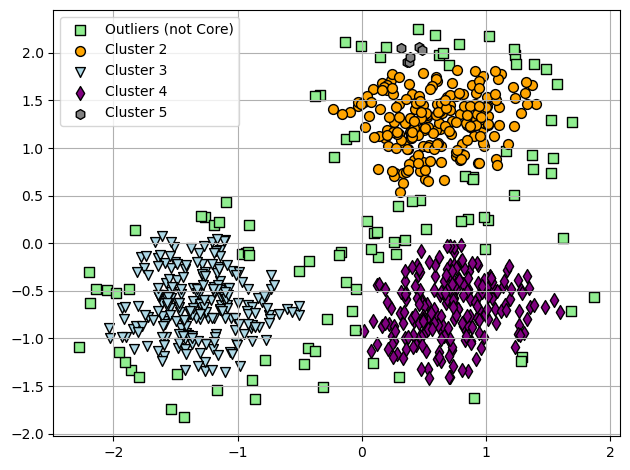

In [24]:
# Visualizing using the code from the textbook
plt.scatter(df.loc[y_db == -1].f1, df.loc[y_db == -1].f2, s=50, c='lightgreen', marker='s', edgecolor='black', label='Outliers (not Core)') 
plt.scatter(df.loc[y_db == 0].f1, df.loc[y_db == 0].f2, s=50, c='orange', marker='o', edgecolor='black', label='Cluster 2') 
plt.scatter(df.loc[y_db == 1].f1, df.loc[y_db == 1].f2, s=50, c='lightblue', marker='v', edgecolor='black', label='Cluster 3') 
plt.scatter(df.loc[y_db == 2].f1, df.loc[y_db == 2].f2, s=50, c='purple', marker='d', edgecolor='black', label='Cluster 4') 
plt.scatter(df.loc[y_db == 3].f1, df.loc[y_db == 3].f2, s=50, c='grey', marker='h', edgecolor='black', label='Cluster 5') 
plt.legend(scatterpoints=1) 
plt.grid() 
plt.tight_layout() 
plt.show()

In [25]:
db = DBSCAN(metric='euclidean', eps=0.15, min_samples=14)

y_db = db.fit_predict(df[['f1', 'f2']])

In [26]:
np.unique(y_db)

array([-1,  0,  1,  2], dtype=int64)

Huh now there's no cluster 5.

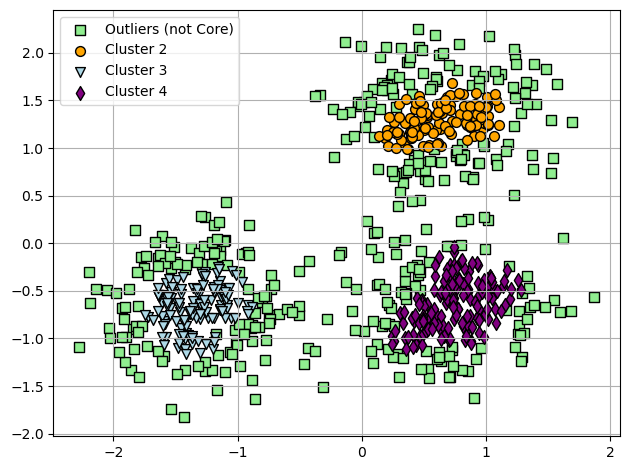

In [27]:
# Visualizing using the code from the textbook
plt.scatter(df.loc[y_db == -1].f1, df.loc[y_db == -1].f2, s=50, c='lightgreen', marker='s', edgecolor='black', label='Outliers (not Core)') 
plt.scatter(df.loc[y_db == 0].f1, df.loc[y_db == 0].f2, s=50, c='orange', marker='o', edgecolor='black', label='Cluster 2') 
plt.scatter(df.loc[y_db == 1].f1, df.loc[y_db == 1].f2, s=50, c='lightblue', marker='v', edgecolor='black', label='Cluster 3') 
plt.scatter(df.loc[y_db == 2].f1, df.loc[y_db == 2].f2, s=50, c='purple', marker='d', edgecolor='black', label='Cluster 4') 
plt.legend(scatterpoints=1) 
plt.grid() 
plt.tight_layout() 
plt.show()

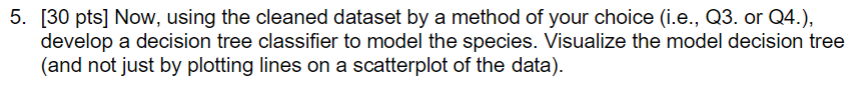

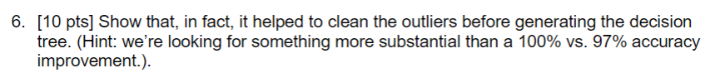

I'm going to use dataset from the KMeans, because I have more control over creating the boundary. Plus, it works because the clusters are circular. If these were core clusters were not circular I would use DBSCAN. 

## Fit a decision tree on original data

In [28]:
X = df[['f1', 'f2']]
y = df.cluster_number

decision_tree = DecisionTreeClassifier(random_state=0)

decision_tree.fit(X, y)

DecisionTreeClassifier(random_state=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


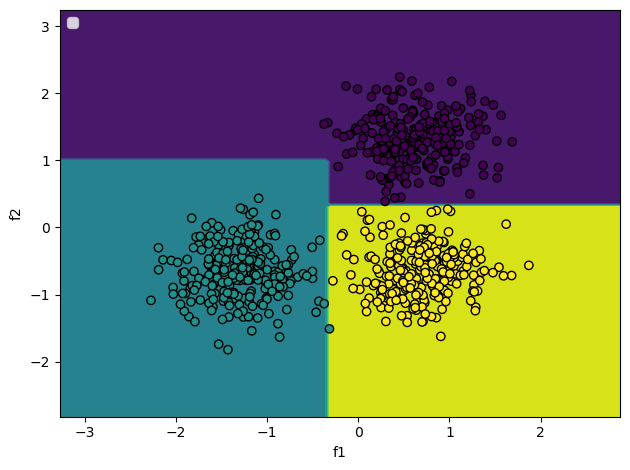

In [29]:
from sklearn.inspection import DecisionBoundaryDisplay # found this from sklearn library
disp = DecisionBoundaryDisplay.from_estimator(
    decision_tree, X, response_method='predict',
    xlabel='f1', ylabel='f2'
)
disp.ax_.scatter(X.f1, X.f2, c=y, edgecolor='k')
plt.xlabel('f1') 
plt.ylabel('f2') 
plt.legend(loc='upper left') 
plt.tight_layout() 
plt.show()

The tree is not bad.

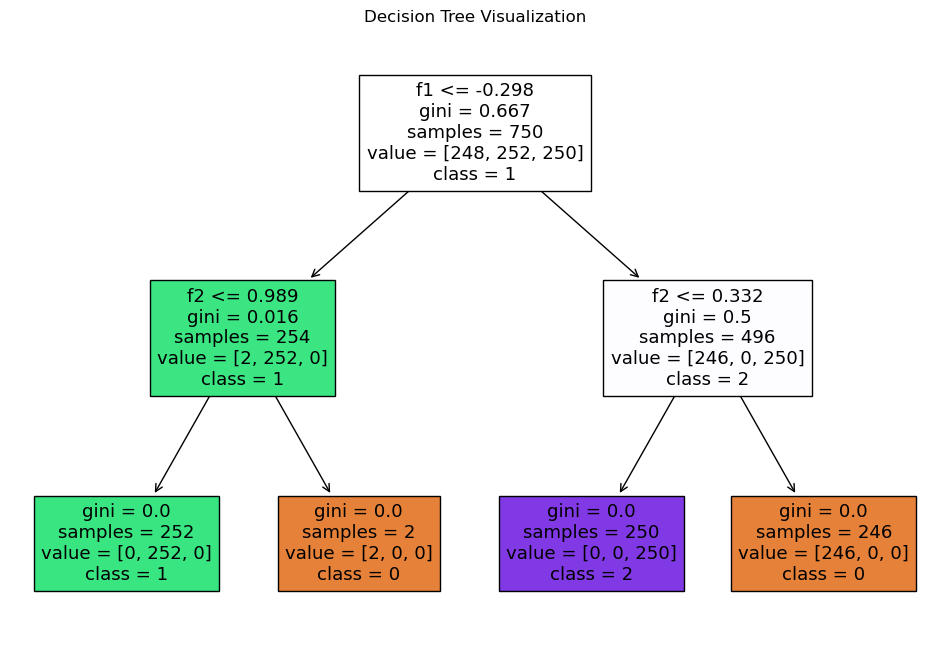

In [30]:
from sklearn import tree
plt.figure(figsize=(12, 8))
tree.plot_tree(decision_tree, feature_names=['f1', 'f2'], class_names=["0", "1", "2", "Outlier"], filled=True)
plt.title("Decision Tree Visualization")
plt.show()


Let's make a model but remove the outliers from the data

In [31]:
filtered_df = df[df.new_cluster_number != 3]
X = filtered_df[['f1', 'f2']]
y = filtered_df.new_cluster_number

decision_tree = DecisionTreeClassifier(random_state=0)

decision_tree.fit(X, y)

DecisionTreeClassifier(random_state=0)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


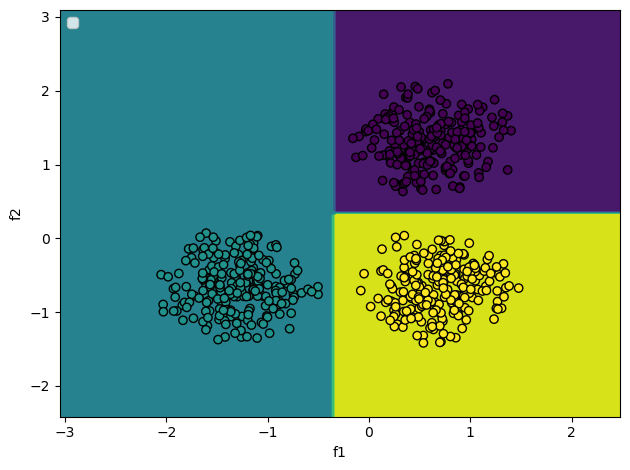

In [32]:
from sklearn.inspection import DecisionBoundaryDisplay
disp = DecisionBoundaryDisplay.from_estimator(
    decision_tree, X, response_method='predict',
    xlabel='f1', ylabel='f2'
)
disp.ax_.scatter(X.f1, X.f2, c=y, edgecolor='k')
plt.xlabel('f1') 
plt.ylabel('f2') 
plt.legend(loc='upper left') 
plt.tight_layout() 
plt.show()

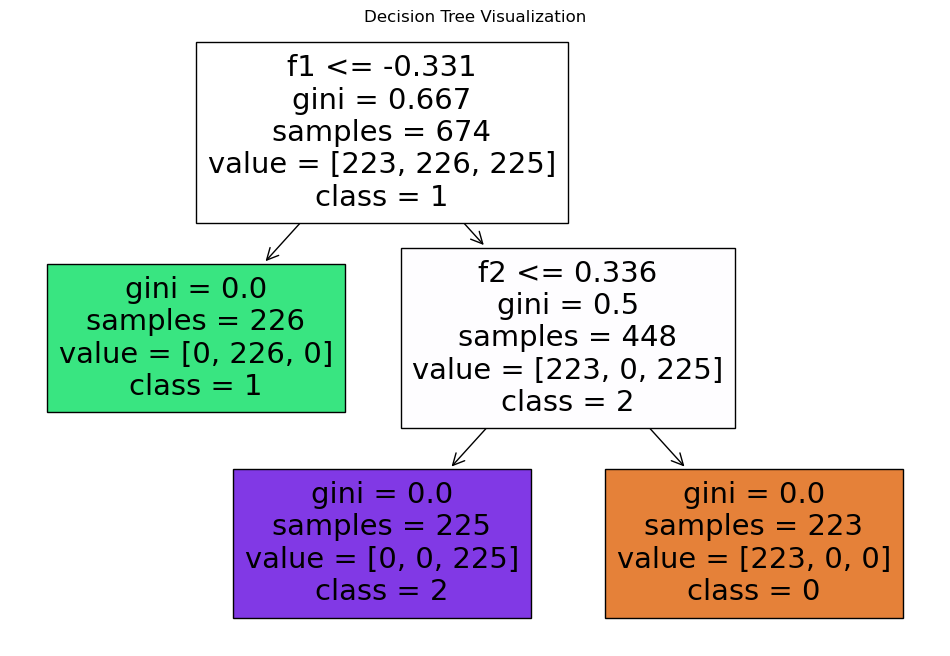

In [33]:
from sklearn import tree
plt.figure(figsize=(12, 8))
tree.plot_tree(decision_tree, feature_names=['f1', 'f2'], class_names=["0", "1", "2"], filled=True)
plt.title("Decision Tree Visualization")
plt.show()


We can see that cleaning the outliers greatly improved the interpretability and generalization of the decision tree.